# Available Input Data
Presentation of the available input datasets can be found [here](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/data)

* [Training Data](#train)
* [County Mapping](#county_map)
* [Client Data](#client)
* [Electricity Price Data](#electricity)
* [Gas Price Data](#gas)
* [Weather / Forecast](#weather_fc)
* [Weather / History](#weather_hist)

In [62]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

<a id='train'></a>
# Training Data

In [63]:
# loading training data file
df_train = pd.read_csv('../../predict-energy-behavior-of-prosumers/train.csv')
df_train["datetime"] = pd.to_datetime(df_train["datetime"])
df_train.shape

(2018352, 9)

In [64]:
df_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              2018352 non-null  int64         
 1   is_business         2018352 non-null  int64         
 2   product_type        2018352 non-null  int64         
 3   target              2017824 non-null  float64       
 4   is_consumption      2018352 non-null  int64         
 5   datetime            2018352 non-null  datetime64[ns]
 6   data_block_id       2018352 non-null  int64         
 7   row_id              2018352 non-null  int64         
 8   prediction_unit_id  2018352 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [65]:
df_train.describe(include='all')

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2018352,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,2022-07-20 08:29:25.326166016,3.218746e+02,1.009176e+06,3.304538e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2021-09-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,2022-02-14 04:00:00,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,2022-07-21 09:30:00,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,2022-12-24 14:00:00,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,2023-05-31 23:00:00,6.370000e+02,2.018351e+06,6.800000e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,NaN,1.826343e+02,5.826482e+05,1.959059e+01


In [66]:
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [67]:
df_train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id'],
      dtype='object')

All rows sharing the same `data_block_id will` be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictins made on October 31st is 100 then the historic weather `data_block_id` for October 31st will be 101 as the historic weather data is only actually available the next day.

In [86]:
df_train["data_block_id"].value_counts()

data_block_id
452    3312
450    3312
436    3312
437    3312
438    3312
       ... 
26     2928
27     2928
28     2928
29     2928
0      2928
Name: count, Length: 638, dtype: int64

From the info we get, we know that `is_consumption` is a boolean for wheter or not the `target` amount is consumption or not. The `target` amount is defined by 
* `county` -> An ID code for the Estonian county (i.e. Harjumaa, Tartumaa..).
* `is_business` -> Boolean for whether or not the prosumer is a business
* `product_type` -> ID code with the following mapping of codes to contract types: `{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`

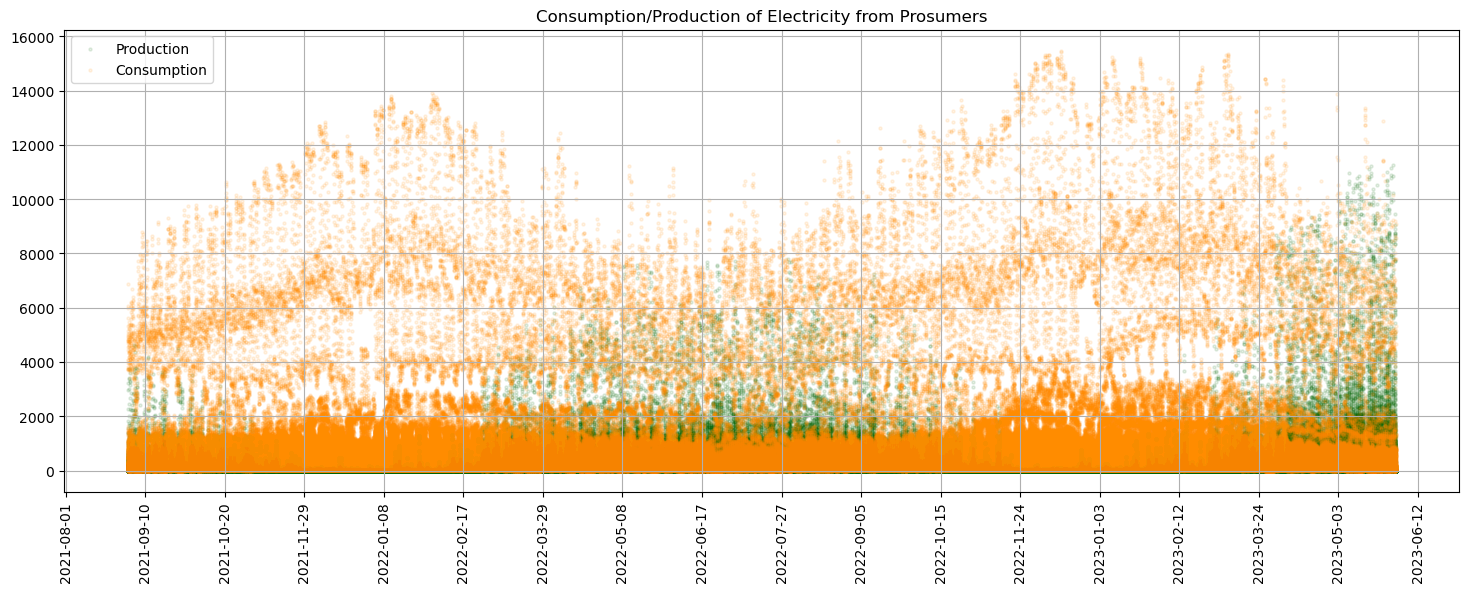

In [68]:
fig, ax = plt.subplots(figsize=(18,6))
point_size = 5
ax.scatter(
    df_train[df_train.is_consumption==0].datetime, 
    df_train[df_train.is_consumption==0].target,
    label='Production', 
    alpha=0.1, 
    s=point_size,
    color="darkgreen"
)
ax.scatter(
    df_train[df_train.is_consumption==1].datetime, 
    df_train[df_train.is_consumption==1].target,
    label='Consumption', 
    alpha=0.1, 
    s=point_size,
    color="darkorange"
)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Consumption/Production of Electricity from Prosumers')
plt.grid()
plt.show()

Question: ***what's the unit of measure of the target?*** 
* KWh?
* Wh?


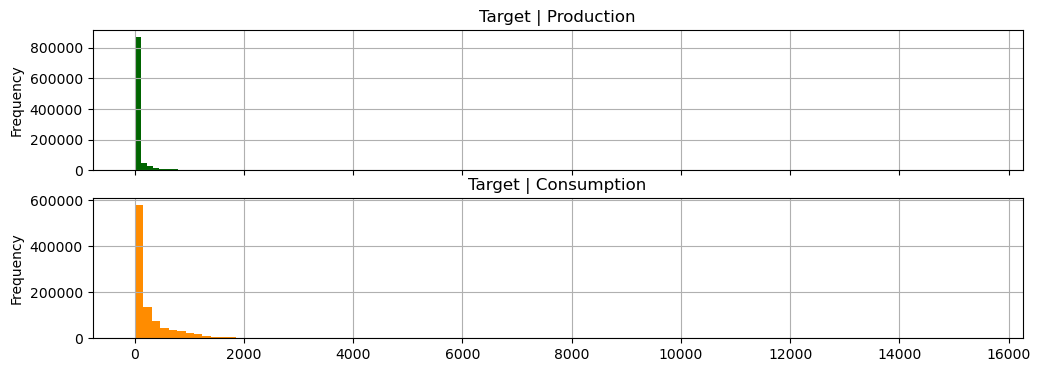

In [69]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(2,1,1)
df_train[df_train.is_consumption==0].target.plot(
    kind='hist', 
    bins=100,
    color="darkgreen"
)
plt.title('Target | Production')
plt.grid()
ax2 = plt.subplot(2,1,2, sharex=ax1)
df_train[df_train.is_consumption==1].target.plot(
    kind='hist', 
    bins=100,
    color="darkorange"
)
plt.title('Target | Consumption')
plt.grid()
plt.show()

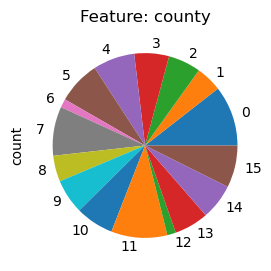

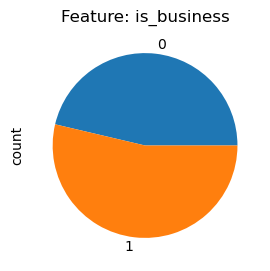

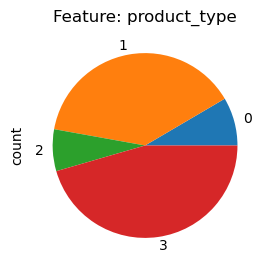

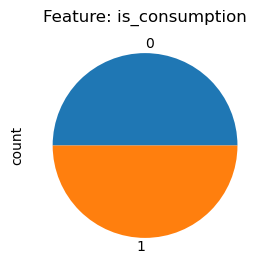

In [70]:
# categorical features
features_cat = ['county','is_business','product_type','is_consumption']

# plot distributions
for f in features_cat:
    plt.figure(figsize=(6,3))
    df_train[f].value_counts().sort_index().plot(kind='pie')
    plt.title(f"Feature: {f}")
    plt.grid()
    plt.show()

<a id='county_map'></a>
## County Mapping

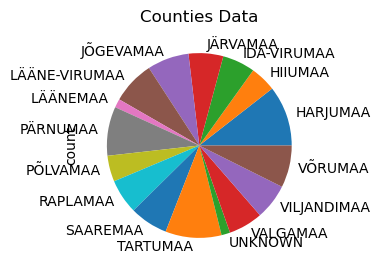

In [71]:
f = open('../../predict-energy-behavior-of-prosumers/county_id_to_name_map.json')
county_map = json.load(f)
county_map = {int(key): value for key, value in county_map.items()}

df_train["county"] = df_train["county"].map(county_map)

plt.figure(figsize=(6,3))
df_train["county"].value_counts().sort_index().plot(kind='pie')
plt.title("Counties Data")
plt.grid()
plt.show()

<a id='client'></a>
## Client Data

* `eic_count` is The aggregated number of consumption points (EICs - European Identifier Code).
* `installed_capacity` is Installed photovoltaic solar panel capacity in kilowatts.

In [75]:
df_client = pd.read_csv('../../predict-energy-behavior-of-prosumers/client.csv')
df_client["county"] = df_client["county"].map(county_map)
df_client.shape

(41919, 7)

In [76]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  object 
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 2.2+ MB


In [77]:
df_client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,HARJUMAA,108,952.89,0,2021-09-01,2
1,2,HARJUMAA,17,166.40,0,2021-09-01,2
2,3,HARJUMAA,688,7207.88,0,2021-09-01,2
3,0,HARJUMAA,5,400.00,1,2021-09-01,2
4,1,HARJUMAA,43,1411.00,1,2021-09-01,2


In [78]:
df_client.describe(include='all')

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
count,41919.000000,41919,41919.000000,41919.000000,41919.000000,41919,41919.000000
unique,NaN,16,NaN,NaN,NaN,636,NaN
top,NaN,HARJUMAA,NaN,NaN,NaN,2022-11-26,NaN
freq,NaN,4422,NaN,NaN,NaN,69,NaN
mean,1.898996,NaN,73.345118,1450.771451,0.536773,NaN,322.898876
std,1.081713,NaN,144.064389,2422.233120,0.498652,NaN,182.075724
min,0.000000,NaN,5.000000,5.500000,0.000000,NaN,2.000000
25%,1.000000,NaN,13.000000,321.900000,0.000000,NaN,167.000000
50%,2.000000,NaN,32.000000,645.200000,1.000000,NaN,324.000000
75%,3.000000,NaN,70.000000,1567.150000,1.000000,NaN,480.000000


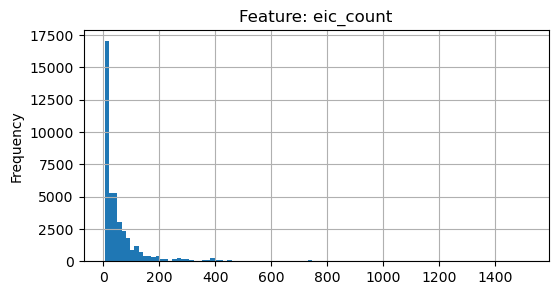

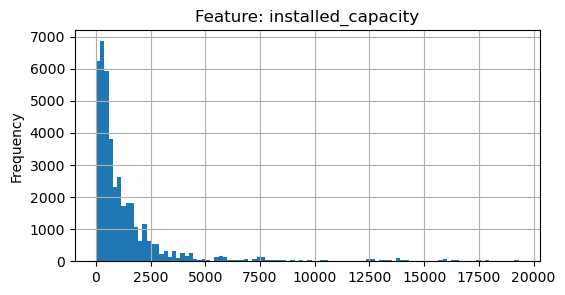

In [79]:
features_num = ['eic_count','installed_capacity']

# plot distributions
for f in features_num:
    plt.figure(figsize=(6,3))
    df_client[f].plot(kind='hist', bins=100)
    plt.title("Feature: " + f)
    plt.grid()
    plt.show()

<a id='electricity'></a>
## Electricity Prices 

For Electricity prices we have, hourly day-ahead predictions 
* `origin_date` is the day the forecast was made
* `forecast_date` is the day-ahead

In [96]:
df_electricity = pd.read_csv('../../predict-energy-behavior-of-prosumers/electricity_prices.csv')
df_electricity["forecast_date"] = pd.to_datetime(df_electricity["forecast_date"])
df_electricity["origin_date"] = pd.to_datetime(df_electricity["origin_date"])
df_electricity.shape

(15286, 4)

In [97]:
df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 477.8 KB


In [98]:
df_electricity.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [99]:
df_electricity.tail()

,forecast_date,euros_per_mwh,origin_date,data_block_id
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637
15285,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,637


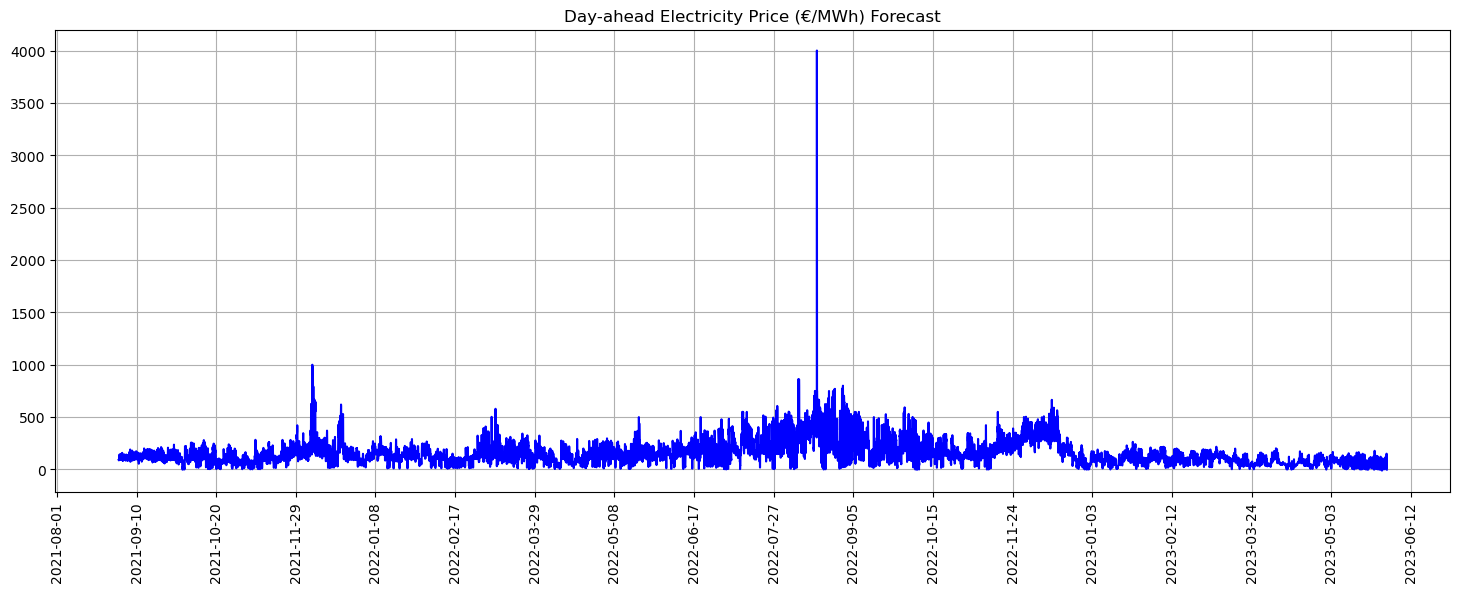

In [100]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(
    df_electricity.forecast_date, 
    df_electricity.euros_per_mwh,
    color="blue"
)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)
plt.title('Day-ahead Electricity Price (€/MWh) Forecast')
plt.grid()
plt.show()

/Users/dylantartarini/miniconda3/envs/enefit/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dylantartarini/miniconda3/envs/enefit/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dylantartarini/miniconda3/envs/enefit/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dylantartarini/miniconda3/envs/enefit/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

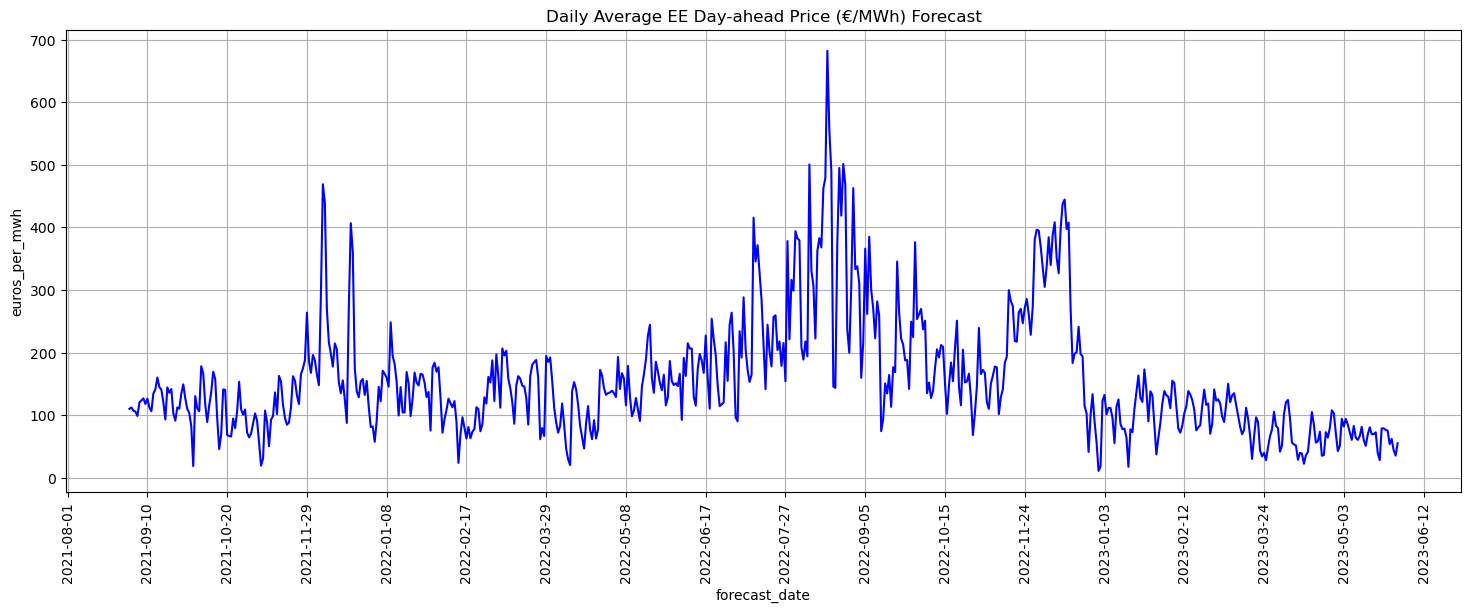

In [104]:
daily_elec_prices = (
    df_electricity[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot( 
    daily_elec_prices.euros_per_mwh,
    color="blue"
)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)
plt.title('Daily Average EE Day-ahead Price (€/MWh) Forecast')
plt.grid()
plt.show()


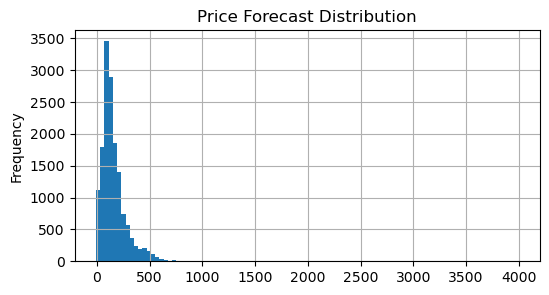

In [102]:
plt.figure(figsize=(6,3))
df_electricity["euros_per_mwh"].plot(kind='hist', bins=100)
plt.title("Price Forecast Distribution")
plt.grid()
plt.show()

<a id='gas'></a>
## Gas Prices
For Gas Prices, we have daily forecasts with the lowest and highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.

In [107]:
df_gas = pd.read_csv('../../predict-energy-behavior-of-prosumers/gas_prices.csv')
df_gas["forecast_date"] = pd.to_datetime(df_gas["forecast_date"])
df_gas["origin_date"] = pd.to_datetime(df_gas["origin_date"])
df_gas.shape

(637, 5)

In [108]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 25.0 KB


In [111]:
df_gas.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [113]:
df_gas.tail()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636
636,2023-05-30,29.00,34.00,2023-05-29,637


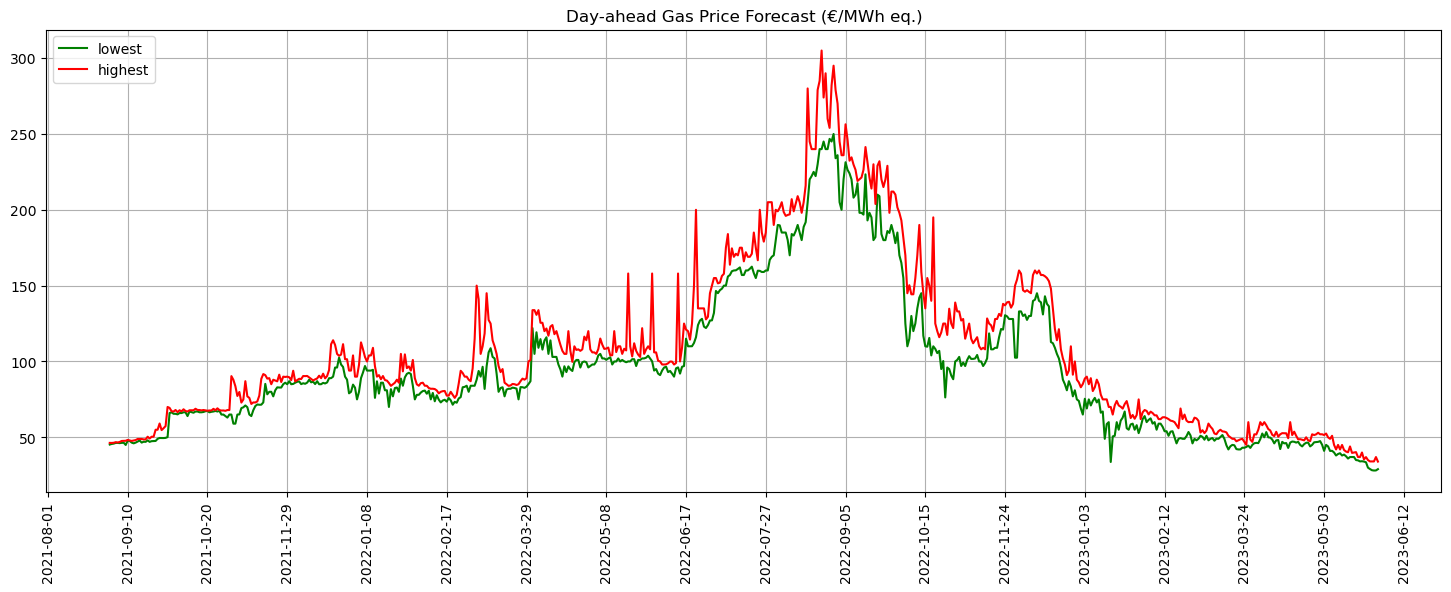

In [117]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_gas.forecast_date, df_gas.lowest_price_per_mwh, label='lowest',
        color="green")
ax.plot(df_gas.forecast_date, df_gas.highest_price_per_mwh, label='highest',
        color="red")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title("Day-ahead Gas Price Forecast (€/MWh eq.)")
plt.grid()
plt.show()

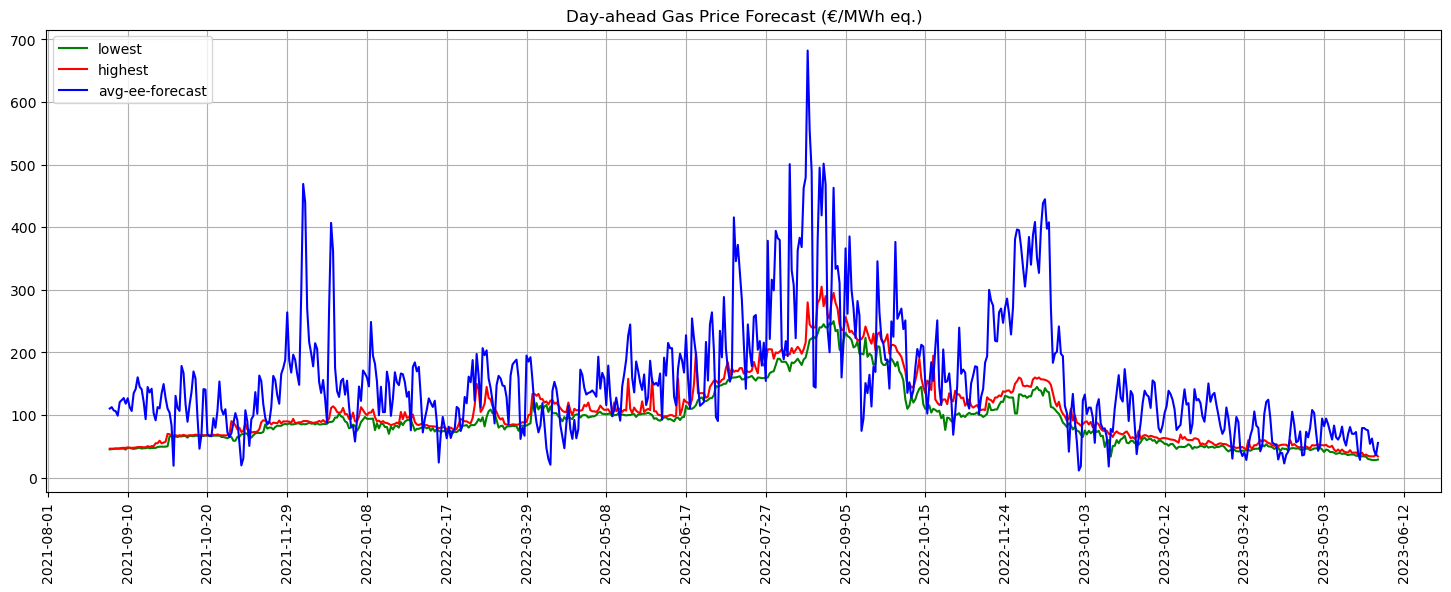

In [119]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_gas.forecast_date, df_gas.lowest_price_per_mwh, label='lowest',
        color="green")
ax.plot(df_gas.forecast_date, df_gas.highest_price_per_mwh, label='highest',
        color="red")
ax.plot(daily_elec_prices, label="avg-ee-forecast", color="blue")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title("Price Forecasts Comparison (€/MWh eq.)")
plt.grid()
plt.show()

<a id='weather_fc'></a>
## Weather / Forecast 

Weather forecasts that would have been available at prediction time. Sourced from the [European Centre for Medium-Range Weather Forecasts](https://codes.ecmwf.int/grib/param-db/?filter=grib2).

* `[latitude/longitude]`: The coordinates of the weather forecast.
* `origin_datetime`: The timestamp of when the forecast was generated.
* `hours_ahead`: The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
* `temperature` - The air temperature at 2 meters above ground in degrees Celsius.
* `dewpoint` - The dew point temperature at 2 meters above ground in degrees Celsius.
* `cloudcover_[low/mid/high/total]` - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
* `10_metre_[u/v]_wind_component` - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second.
data_block_id
* `forecast_datetime`: The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead.
* `direct_solar_radiation`: The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
* `surface_solar_radiation_downwards`: The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
* `snowfall`: Snowfall over the previous hour in units of meters of water equivalent.
* `total_precipitation`: The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.

In [120]:
df_weather_fc = pd.read_csv('../../predict-energy-behavior-of-prosumers/forecast_weather.csv')
df_weather_fc.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   latitude                           3424512 non-null  float64
 1   longitude                          3424512 non-null  float64
 2   origin_datetime                    3424512 non-null  object 
 3   hours_ahead                        3424512 non-null  int64  
 4   temperature                        3424512 non-null  float64
 5   dewpoint                           3424512 non-null  float64
 6   cloudcover_high                    3424512 non-null  float64
 7   cloudcover_low                     3424512 non-null  float64
 8   cloudcover_mid                     3424512 non-null  float64
 9   cloudcover_total                   3424512 non-null  float64
 10  10_metre_u_wind_component          3424512 non-null  float64
 11  10_metre_v_wind_componen

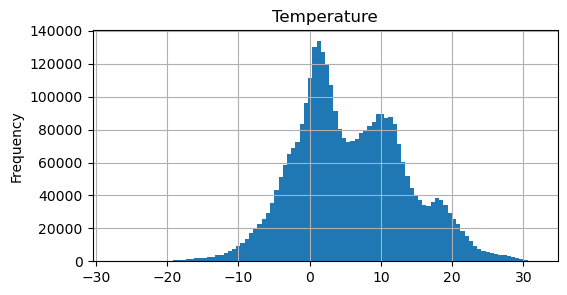

In [121]:
# plot temperature
plt.figure(figsize=(6,3))
df_weather_fc.temperature.plot(
    kind='hist', 
    bins=100
    )
plt.title('Temperature')
plt.grid()
plt.show()

Select a specific location, like Tallin city

In [125]:
df_ex = df_weather_fc[(df_weather_fc.latitude==59.4) & (df_weather_fc.longitude==24.7)]
df_ex.shape

(30576, 18)

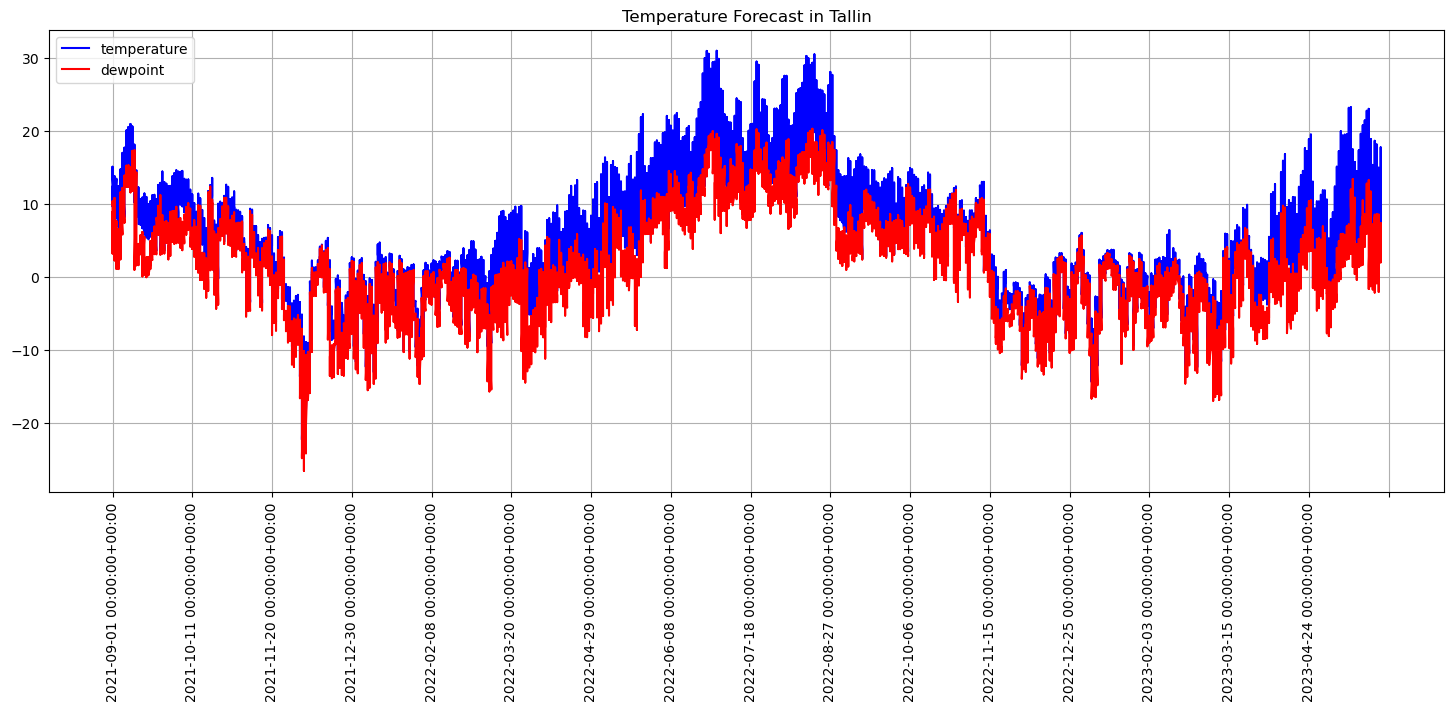

In [133]:
# plot time series for temperature
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_ex.origin_datetime, df_ex.temperature, label='temperature',
        color="blue")
ax.plot(df_ex.origin_datetime, df_ex.dewpoint, label='dewpoint',
        color="red")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Temperature Forecast in Tallin')
plt.grid()
plt.show()

<a id='weather_hist'></a>
## Weather / History
from the [Weather Forecast API](https://open-meteo.com/en/docs)
* `datetime`
* `temperature`
* `dewpoint`
* `rain`: Different from the forecast conventions. The rain from large scale weather systems of the preceding hour in millimeters.
* `snowfall`: Different from the forecast conventions. Snowfall over the preceding hour in centimeters.
* `surface_pressure`: The air pressure at surface in hectopascals.
* `cloudcover_[low/mid/high/total]`: Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
* `windspeed_10m`: Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
* `winddirection_10m`: Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
* `shortwave_radiation`: Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
* `direct_solar_radiation`
* `diffuse_radiation`: Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
* `[latitude/longitude]` The coordinates of the weather station.
* `data_block_id`

In [127]:
df_weather_hist = pd.read_csv('../../predict-energy-behavior-of-prosumers/historical_weather.csv')
df_weather_hist.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   datetime                1710800 non-null  object 
 1   temperature             1710800 non-null  float64
 2   dewpoint                1710800 non-null  float64
 3   rain                    1710800 non-null  float64
 4   snowfall                1710800 non-null  float64
 5   surface_pressure        1710800 non-null  float64
 6   cloudcover_total        1710800 non-null  int64  
 7   cloudcover_low          1710800 non-null  int64  
 8   cloudcover_mid          1710800 non-null  int64  
 9   cloudcover_high         1710800 non-null  int64  
 10  windspeed_10m           1710800 non-null  float64
 11  winddirection_10m       1710800 non-null  int64  
 12  shortwave_radiation     1710800 non-null  float64
 13  direct_solar_radiation  1710800 non-null  float64
 14  di

In [128]:
df_weather_hist.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
2,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
3,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
4,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1


In [129]:
# pick specific location
df_ex_hist = df_weather_hist[(df_weather_hist.latitude==59.4) & (df_weather_hist.longitude==24.7)]
df_ex_hist.shape

(15275, 18)

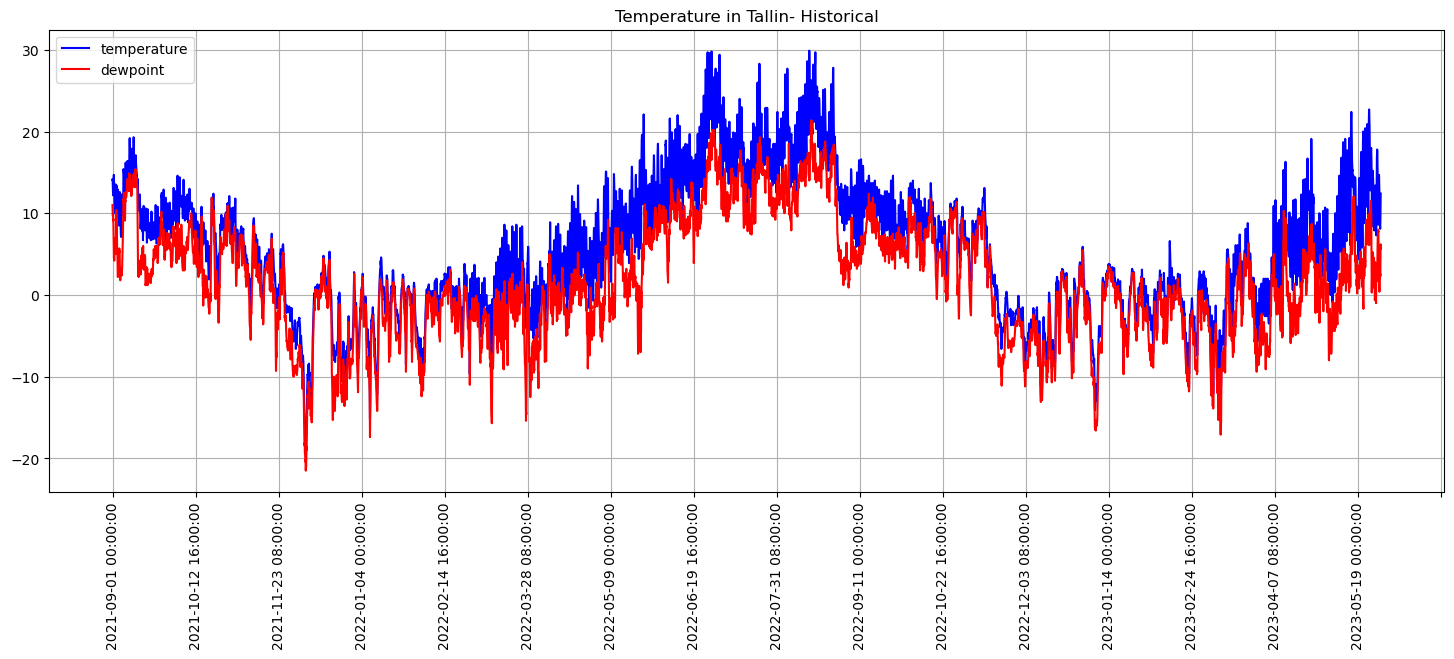

In [134]:
# plot time series for temperature
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_ex_hist.datetime, df_ex_hist.temperature, label='temperature',
        color="blue")
ax.plot(df_ex_hist.datetime, df_ex_hist.dewpoint, label='dewpoint',
        color="red")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Temperature in Tallin- Historical')
plt.grid()
plt.show()

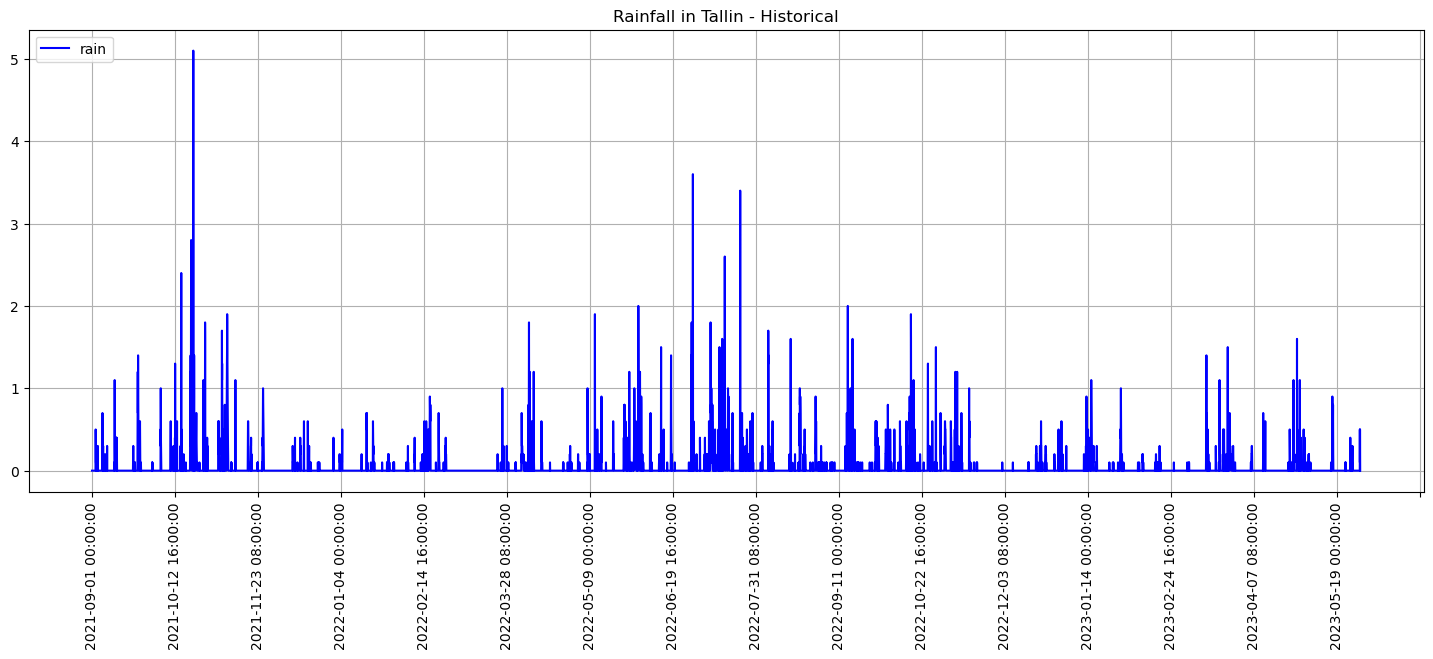

In [139]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_ex_hist.datetime, df_ex_hist.rain, label='rain',
        color="blue")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Rainfall in Tallin - Historical')
plt.grid()
plt.show()

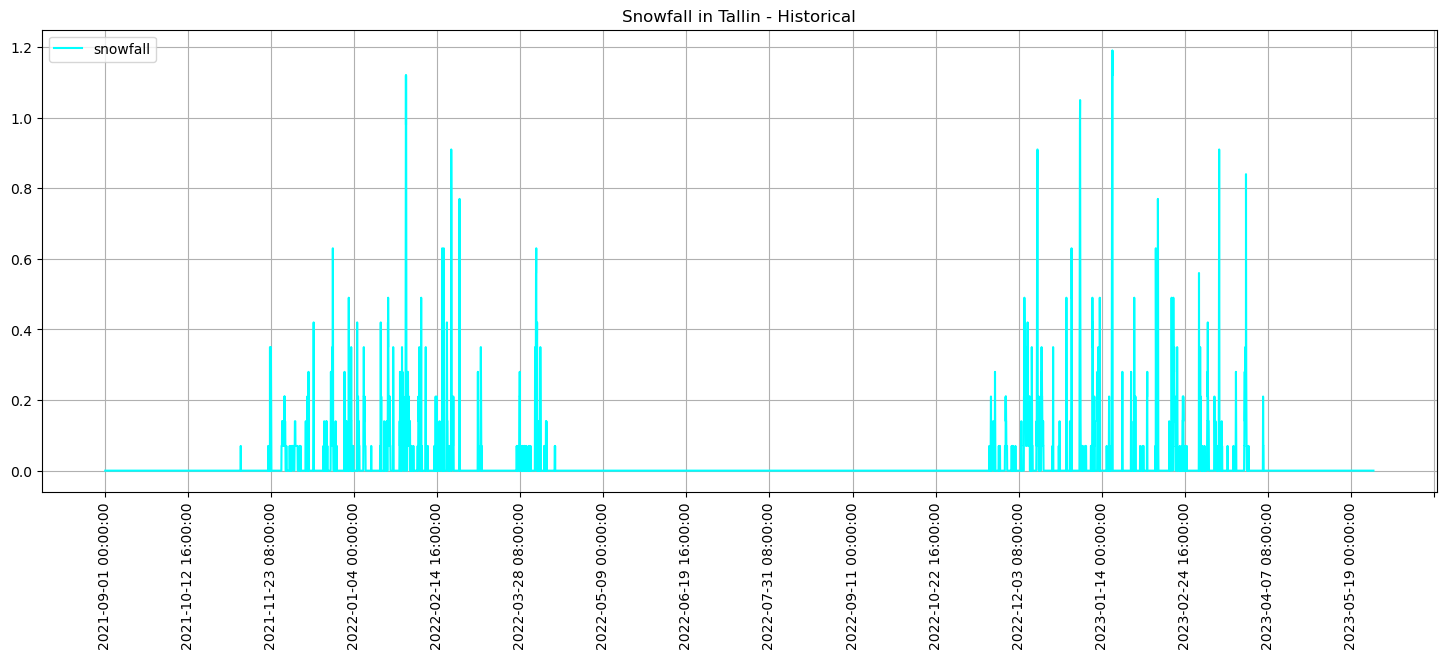

In [140]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_ex_hist.datetime, df_ex_hist.snowfall, label='snowfall',
        color="cyan")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Snowfall in Tallin - Historical')
plt.grid()
plt.show()

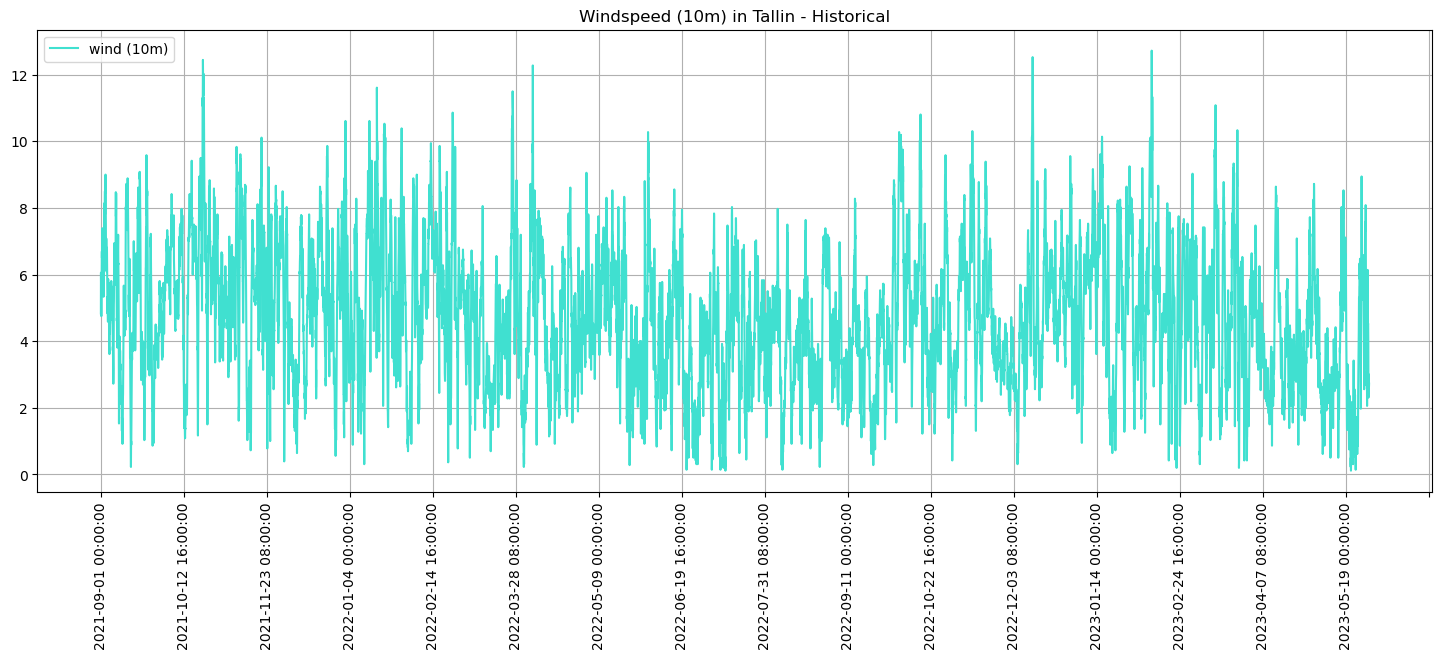

In [142]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_ex_hist.datetime, df_ex_hist.windspeed_10m, label='wind (10m)',
        color="turquoise")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.title('Windspeed (10m) in Tallin - Historical')
plt.grid()
plt.show()